# Starter Notebook

With some code from
_https://www.kaggle.com/pestipeti/pytorch-starter-fasterrcnn-train_

# Utilities

Utilities for data loading, etc.

In [1]:
%matplotlib inline

import albumentations as A
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import torch
import torchvision

from albumentations.pytorch.transforms import ToTensor
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SequentialSampler
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

%load_ext autoreload
%autoreload 2

In [2]:
base_path = os.path.join('..', 'data')
train_path = os.path.join(base_path, 'train')
test_path = os.path.join(base_path, 'test')

In [3]:
train_df = pd.read_csv(os.path.join(base_path, 'train.csv'))
train_df

,image_id,width,height,bbox,source
0,b6ab77fd7,1024,1024,"[834.0, 222.0, 56.0, 36.0]",usask_1
1,b6ab77fd7,1024,1024,"[226.0, 548.0, 130.0, 58.0]",usask_1
2,b6ab77fd7,1024,1024,"[377.0, 504.0, 74.0, 160.0]",usask_1
3,b6ab77fd7,1024,1024,"[834.0, 95.0, 109.0, 107.0]",usask_1
4,b6ab77fd7,1024,1024,"[26.0, 144.0, 124.0, 117.0]",usask_1
...,...,...,...,...,...
147788,5e0747034,1024,1024,"[64.0, 619.0, 84.0, 95.0]",arvalis_2
147789,5e0747034,1024,1024,"[292.0, 549.0, 107.0, 82.0]",arvalis_2
147790,5e0747034,1024,1024,"[134.0, 228.0, 141.0, 71.0]",arvalis_2
147791,5e0747034,1024,1024,"[430.0, 13.0, 184.0, 79.0]",arvalis_2


In [4]:
train_df['x'] = -1
train_df['y'] = -1
train_df['w'] = -1
train_df['h'] = -1
bboxes = train_df['bbox'].copy().apply(lambda x: eval(x))
train_df[['x', 'y', 'w', 'h']] = np.stack(bboxes).astype(int)
train_df

,image_id,width,height,bbox,source,x,y,w,h
0,b6ab77fd7,1024,1024,"[834.0, 222.0, 56.0, 36.0]",usask_1,834,222,56,36
1,b6ab77fd7,1024,1024,"[226.0, 548.0, 130.0, 58.0]",usask_1,226,548,130,58
2,b6ab77fd7,1024,1024,"[377.0, 504.0, 74.0, 160.0]",usask_1,377,504,74,160
3,b6ab77fd7,1024,1024,"[834.0, 95.0, 109.0, 107.0]",usask_1,834,95,109,107
4,b6ab77fd7,1024,1024,"[26.0, 144.0, 124.0, 117.0]",usask_1,26,144,124,117
...,...,...,...,...,...,...,...,...,...
147788,5e0747034,1024,1024,"[64.0, 619.0, 84.0, 95.0]",arvalis_2,64,619,84,95
147789,5e0747034,1024,1024,"[292.0, 549.0, 107.0, 82.0]",arvalis_2,292,549,107,82
147790,5e0747034,1024,1024,"[134.0, 228.0, 141.0, 71.0]",arvalis_2,134,228,141,71
147791,5e0747034,1024,1024,"[430.0, 13.0, 184.0, 79.0]",arvalis_2,430,13,184,79


In [5]:
image_ids = train_df['image_id'].unique()
valid_ids = image_ids[-665:]
train_ids = image_ids[:-665]
valid_df = train_df[train_df['image_id'].isin(valid_ids)]
train_df = train_df[train_df['image_id'].isin(train_ids)]

# Show Example

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


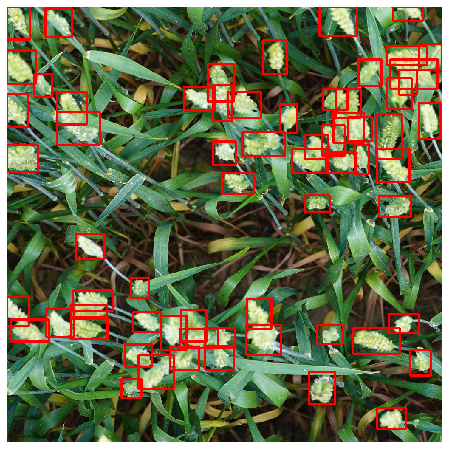

In [6]:
image_id = 'c14c1e300'
image = cv2.imread(os.path.join(train_path, f'{image_id}.jpg'), cv2.IMREAD_COLOR)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
image /= 255.0

bboxes = train_df[train_df.image_id == image_id][['x', 'y', 'w', 'h']]

fig, ax = plt.subplots(1, 1, figsize=(16, 8))

for index, row in bboxes.iterrows():
    cv2.rectangle(image, 
                  (row['x'], row['y']), 
                  (row['x'] + row['w'], row['y'] + row['h']), 
                  (220, 0, 0,), 3)

ax.set_axis_off()
ax.imshow(image)

plt.show()

In [7]:
class WheatDataset(Dataset):
    # taken from  https://www.kaggle.com/pestipeti/pytorch-starter-fasterrcnn-train

    def __init__(self, dataframe, image_dir, transforms=None):
        super().__init__()

        self.image_ids = dataframe['image_id'].unique()
        self.df = dataframe
        self.image_dir = image_dir
        self.transforms = transforms

    def __getitem__(self, index: int):

        image_id = self.image_ids[index]
        records = self.df[self.df['image_id'] == image_id]

        image = cv2.imread(f'{self.image_dir}/{image_id}.jpg', cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0

        boxes = records[['x', 'y', 'w', 'h']].values
        boxes[:, 2] = boxes[:, 0] + boxes[:, 2]
        boxes[:, 3] = boxes[:, 1] + boxes[:, 3]
        
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        area = torch.as_tensor(area, dtype=torch.float32)

        # there is only one class
        labels = torch.ones((records.shape[0],), dtype=torch.int64)
        
        # suppose all instances are not crowd
        iscrowd = torch.zeros((records.shape[0],), dtype=torch.int64)
        
        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        # target['masks'] = None
        target['image_id'] = torch.tensor([index])
        target['area'] = area
        target['iscrowd'] = iscrowd

        if self.transforms:
            sample = {
                'image': image,
                'bboxes': target['boxes'],
                'labels': labels
            }
            sample = self.transforms(**sample)
            image = sample['image']
            
            target['boxes'] = torch.stack(tuple(map(torch.tensor, zip(*sample['bboxes'])))).permute(1, 0)

        return image, target, image_id

    def __len__(self) -> int:
        return self.image_ids.shape[0]

In [8]:
# Albumentations
def get_train_transform():
    return A.Compose([
        A.Flip(0.5),
        ToTensor()
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

def get_valid_transform():
    return A.Compose([
        ToTensor()
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})


# Basic Model Setup

In [9]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

In [10]:
num_classes = 2  # 1 class (wheat) + background

# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [11]:
class Averager:
    def __init__(self):
        self.current_total = 0.0
        self.iterations = 0.0

    def send(self, value):
        self.current_total += value
        self.iterations += 1

    @property
    def value(self):
        if self.iterations == 0:
            return 0
        else:
            return 1.0 * self.current_total / self.iterations

    def reset(self):
        self.current_total = 0.0
        self.iterations = 0.0


In [12]:
def collate_fn(batch):
    return tuple(zip(*batch))

train_dataset = WheatDataset(train_df, train_path, get_train_transform())
valid_dataset = WheatDataset(valid_df, train_path, get_valid_transform())


# split the dataset in train and test set
indices = torch.randperm(len(train_dataset)).tolist()

train_data_loader = DataLoader(
    train_dataset,
    batch_size=4,
    shuffle=False,
    num_workers=0,
    collate_fn=collate_fn
)

valid_data_loader = DataLoader(
    valid_dataset,
    batch_size=4,
    shuffle=False,
    num_workers=0,
    collate_fn=collate_fn
)

# Train the Model

In [13]:
model.to(device)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
# lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
lr_scheduler = None

num_epochs = 2

In [14]:
loss_hist = Averager()
itr = 1

for epoch in range(num_epochs):
    loss_hist.reset()
    
    for images, targets, image_ids in train_data_loader:
        
        images = list(image.to(device) for image in images)
#         targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        targets = [{k: v.long().to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)

        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()

        loss_hist.send(loss_value)

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        if itr % 50 == 0:
            print(f"Iteration #{itr} loss: {loss_value}")

        itr += 1
    
    # update the learning rate
    if lr_scheduler is not None:
        lr_scheduler.step()

    print(f"Epoch #{epoch} loss: {loss_hist.value}")   

C:\Users\Alan\Anaconda3\envs\wheat-detection\lib\site-packages\torch\nn\functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "
..\torch\csrc\utils\python_arg_parser.cpp:756: UserWarning: This overload of nonzero is deprecated:
	nonzero(Tensor input, *, Tensor out)
Consider using one of the following signatures instead:
	nonzero(Tensor input, *, bool as_tuple)


Iteration #50 loss: 0.5877764225006104
Iteration #100 loss: 0.7367486953735352
Iteration #150 loss: 0.791550874710083
Iteration #200 loss: 0.798771858215332
Iteration #250 loss: 0.797427237033844
Iteration #300 loss: 0.7425780296325684
Iteration #350 loss: 0.44907790422439575
Iteration #400 loss: 0.5314803123474121
Iteration #450 loss: 0.5411561727523804
Iteration #500 loss: 0.5773199796676636
Iteration #550 loss: 0.9288208484649658
Iteration #600 loss: 0.5430033802986145
Iteration #650 loss: 0.6426553726196289
Epoch #0 loss: 0.7206489039664783
Iteration #700 loss: 0.7051443457603455
Iteration #750 loss: 0.6926866173744202
Iteration #800 loss: 0.6275629997253418
Iteration #850 loss: 1.1934120655059814
Iteration #900 loss: 0.768406867980957
Iteration #950 loss: 0.6632035970687866
Iteration #1000 loss: 0.5656711459159851
Iteration #1050 loss: 0.6231900453567505
Iteration #1100 loss: 0.6265413761138916
Iteration #1150 loss: 0.5882689356803894
Iteration #1200 loss: 0.48554515838623047
Iter

In [15]:
images, targets, image_ids = next(iter(valid_data_loader))
images = list(img.to(device) for img in images)
targets = [{k: v.long().to(device) for k, v in t.items()} for t in targets]
boxes = targets[1]['boxes'].cpu().numpy().astype(np.int32)
sample = images[1].permute(1,2,0).cpu().numpy()

In [16]:
model.eval()
cpu_device = torch.device("cpu")

outputs = model(images)
outputs = [{k: v.to(cpu_device) for k, v in t.items()} for t in outputs]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


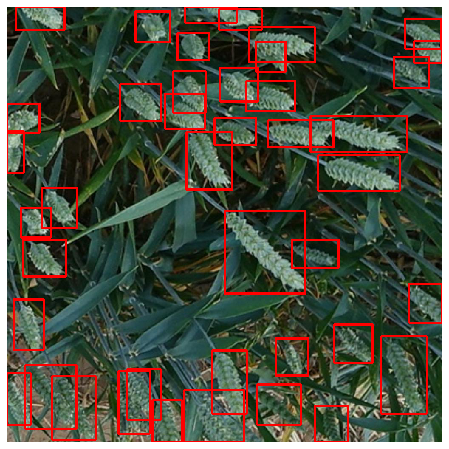

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))

for box in boxes:
    cv2.rectangle(sample,
                  (box[0], box[1]),
                  (box[2], box[3]),
                  (220, 0, 0), 3)
    
ax.set_axis_off()
ax.imshow(sample)

In [18]:
outputs

[{'boxes': tensor([[9.2832e+02, 9.0928e+02, 1.0225e+03, 1.0200e+03],
          [3.0992e+02, 5.8146e+02, 4.4737e+02, 6.8718e+02],
          [9.4278e+02, 8.0320e+02, 1.0235e+03, 9.0980e+02],
          [3.2123e+02, 9.1884e+02, 4.0560e+02, 1.0219e+03],
          [4.7628e+02, 3.1643e+02, 6.2444e+02, 3.9012e+02],
          [5.8243e+02, 5.5776e+01, 6.9976e+02, 1.3268e+02],
          [4.2834e+02, 3.4459e+00, 5.3497e+02, 8.4492e+01],
          [6.0065e+01, 2.4282e+00, 1.4624e+02, 7.2294e+01],
          [8.8933e+02, 1.7507e+02, 9.9437e+02, 2.4125e+02],
          [1.9303e+02, 4.7098e+02, 2.8043e+02, 5.4480e+02],
          [6.7036e+02, 9.1005e+01, 8.1793e+02, 1.8551e+02],
          [3.4312e+02, 8.3104e+02, 4.4751e+02, 9.4897e+02],
          [5.1798e+02, 4.6085e+02, 6.5695e+02, 5.3823e+02],
          [9.4948e+02, 7.0354e+02, 1.0239e+03, 7.7712e+02],
          [5.4432e+02, 7.2201e+02, 7.0073e+02, 7.9970e+02],
          [7.9008e+02, 6.4584e+02, 9.3546e+02, 7.2317e+02],
          [1.5593e+02, 3.0551e+